In [1]:
%autosave 60

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
! pip install pandarallel
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from matplotlib import pyplot as plt
from tqdm import tqdm
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
tqdm.pandas()
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Autosaving every 60 seconds


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
def get_text_and_score(pathes):
    text_score = []
    for path in pathes:
        file_names = os.listdir(path)
        for file_name in file_names:
            with open(f'{path}/{file_name}', 'r') as file:
                text = file.read()
                score = int(file_name.split('.')[0].split('_')[-1])
            text_score.append([text, score])
    return text_score

In [4]:
path = r'data/aclImdb'
corpus = get_text_and_score([f'{path}/train/pos/', f'{path}/train/neg/', 
                             f'{path}/test/pos/', f'{path}/test/neg/'])


In [5]:
dataset = pd.DataFrame(corpus, columns=('data', 'target'))

In [6]:
dataset.isnull().sum()

data      0
target    0
dtype: int64

In [7]:
texts_count = 50000
dataset = dataset.iloc[:texts_count]

In [8]:
dataset.dropna(inplace=True)

(array([4.7880e+03, 1.9264e+04, 1.0831e+04, 5.4310e+03, 3.3380e+03,
        2.0760e+03, 1.3850e+03, 9.2400e+02, 6.1200e+02, 4.4900e+02,
        3.2100e+02, 2.6300e+02, 2.4000e+02, 4.8000e+01, 5.0000e+00,
        8.0000e+00, 3.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   32.        ,   487.73333333,   943.46666667,  1399.2       ,
         1854.93333333,  2310.66666667,  2766.4       ,  3222.13333333,
         3677.86666667,  4133.6       ,  4589.33333333,  5045.06666667,
         5500.8       ,  5956.53333333,  6412.26666667,  6868.        ,
         7323.73333333,  7779.46666667,  8235.2       ,  8690.93333333,
         9146.66666667,  9602.4       , 10058.13333333, 10513.86666667,
        10969.6       , 11425.33333333, 11881.06666667, 12336.8       ,
        12792.53333333, 13248.26666667, 13704.        ]),
 <BarContainer object of 30 

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcd34e949d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcd34e94f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcd34e946a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcd34e95450>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcd34e956f0>],
 'means': []}

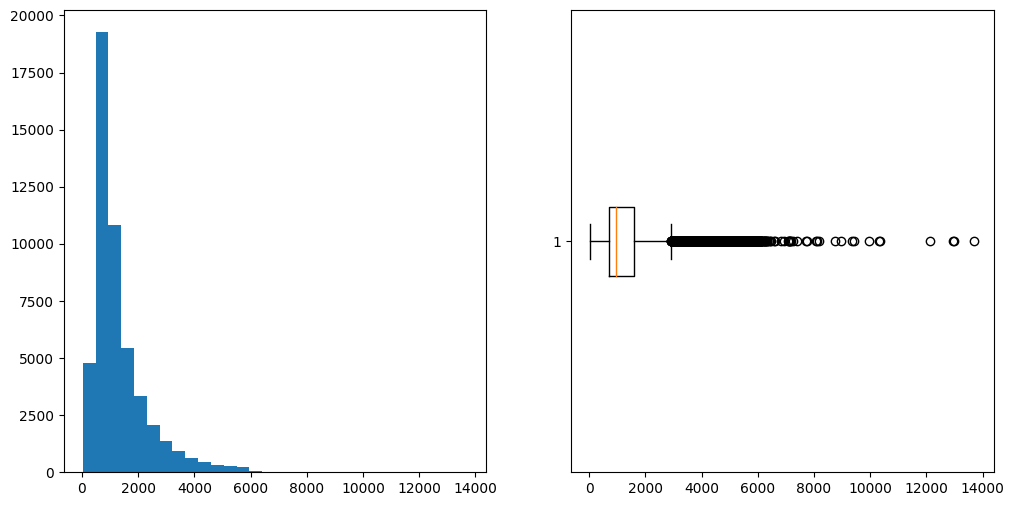

In [9]:
text_lenth = dataset['data'].apply(len)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(text_lenth, 30, label='Гистограмма распределения длин текстов')
axs[1].boxplot(text_lenth, vert=False)

In [10]:
def clean_regex(text):
    text = re.sub('\"{2,3}', '', text)
    text = re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    text = re.sub(r'[.,!?-]', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    
    return text

In [12]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.utils import pad_sequences
from collections import Counter
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True, nb_workers = 8)

nltk.download('stopwords')
nltk.download('wordnet')
stopwords = [word for word in set(stopwords.words('english')) if word not in ('no', 'not')]

2023-08-06 16:25:21.597478: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-06 16:25:22.228325: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-06 16:25:23.471254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/argen7um/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /home/argen7um/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
max_lenth = 1000

In [14]:
def tokenize_text(text):
    return word_tokenize(text)

def split_tords_by_space(text):
    return text.split()

def make_lower(word_list):
    return list(map(lambda t: t.lower(), word_list))

def lemmatize(word_list):
    return list(map(lemmatizer.lemmatize, word_list))

def remove_stop_words(word_list):
    return [word for word in word_list if word not in stopwords]

def add_bos_tag(word_list):
    word_list.insert(0, '<bos>')
    return word_list

def limit_sequence(word_list, max_lenth):
    return word_list[:max_lenth]

def join_word_list(word_list):
    return ' '.join(word_list)

def preprocess_text(text):
    word_list = tokenize_text(text)
    lower_word_list = make_lower(word_list)
    lemmatized_word_list = make_lower(lower_word_list)
    word_list_with_bos = add_bos_tag(remove_stop_words(lemmatized_word_list))
    preprocessed_text = join_word_list(limit_sequence(word_list_with_bos, 1000))
    
    return preprocessed_text

In [17]:
threshold_count = 15
count_words = Counter(nltk.flatten(list(dataset['data'].parallel_apply(clean_regex).parallel_apply(tokenize_text).parallel_apply(make_lower))))

stopwords = set(stopwords)
for word in count_words:
    count = count_words[word]
    if count <= threshold_count:
        stopwords.add(word)
        
stopwords = sorted(list(stopwords))
vocabulary = [word for word in count_words if count_words[word] > threshold_count and word not in stopwords]

In [15]:
# # !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
# %% script false
# lemmatizer = WordNetLemmatizer()
# dataset['cleaned text'] = dataset['data'].parallel_apply(clean_regex)
# dataset['preprocessed text'] = dataset['cleaned text'].parallel_apply(preprocess_text)
# dataset['preprocessed text']

In [16]:
# text_lenth = dataset['preprocessed text'].parallel_apply(len)

In [17]:
dataset

,data,target
0,This show is a great history story. It's has e...,10
1,"A few years ago, a friend got from one of his ...",10
2,"I like this movie a lot, but it's a fact, that...",10
3,"A brilliant movie about family, guilt, sacrifi...",9
4,One of the many Merrie Melodies cartoons that ...,7
...,...,...
49995,If you are a bit masochistic and like to waste...,1
49996,'R Xmas is one of the only films I've seen whe...,4
49997,Ruggero Deodato is often credited for inventin...,4
49998,"""Stick Around"" is one of the brief series of f...",4


In [18]:
# %%script false
# dataset.to_csv('processed_data.csv')

In [18]:
dataset = pd.read_csv('data/processed_data copy.csv')

In [19]:
print(dataset.head())

   Unnamed: 0                                               data  target  \
0           0  This show is a great history story. It's has e...      10   
1           1  A few years ago, a friend got from one of his ...      10   
2           2  I like this movie a lot, but it's a fact, that...      10   
3           3  A brilliant movie about family, guilt, sacrifi...       9   
4           4  One of the many Merrie Melodies cartoons that ...       7   

                                        cleaned text  \
0  This show is a great history story It s has ev...   
1  A few years ago a friend got from one of his o...   
2  I like this movie a lot but it s a fact that y...   
3  A brilliant movie about family guilt sacrifice...   
4  One of the many Merrie Melodies cartoons that ...   

                                   preprocessed text  
0  <bos> show great history story everything way ...  
1  <bos> years ago friend got one friends video m...  
2  <bos> like movie lot fact not understa

In [20]:
def get_vocabulary(data_column):
    word_list_column = list(data_column.parallel_apply(split_tords_by_space))
    vocabulary = sorted(list(set(nltk.flatten(word_list_column))))
    return vocabulary

In [21]:
vocabulary = get_vocabulary(dataset['preprocessed text'])

In [22]:
def word2int(vocabulary):
    word2int_dict = {word : i for i, word in enumerate(vocabulary, 1)}
    int2word_dict = {i : word for word, i in word2int_dict.items()}
    return (word2int_dict, int2word_dict)
        
word2int_dict, int2word_dict = word2int(vocabulary)

In [23]:
vocabulary

['<bos>',
 'aa',
 'aaa',
 'aag',
 'aaliyah',
 'aamir',
 'aardman',
 'aaron',
 'ab',
 'aback',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abandons',
 'abba',
 'abbey',
 'abbie',
 'abbot',
 'abbott',
 'abby',
 'abc',
 'abducted',
 'abduction',
 'abe',
 'abel',
 'abetted',
 'abhay',
 'abhishek',
 'abhorrent',
 'abiding',
 'abigail',
 'abilities',
 'ability',
 'abject',
 'able',
 'ably',
 'abnormal',
 'abo',
 'aboard',
 'abominable',
 'abomination',
 'aboriginal',
 'aborigine',
 'aborigines',
 'aborted',
 'abortion',
 'abortions',
 'abound',
 'abounds',
 'aboveaverage',
 'abraham',
 'abrahams',
 'abrasive',
 'abroad',
 'abrupt',
 'abruptly',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorb',
 'absorbed',
 'absorbing',
 'abstract',
 'absurd',
 'absurdist',
 'absurdities',
 'absurdity',
 'absurdly',
 'abu',
 'abundance',
 'abundant',
 'abuse',
 'abused',
 'abuses',
 'abusing',
 'abusive',
 'abysmal',
 'abysmally',
 'abyss',
 'ac',
 'academic',
 'academy',
 'accent'

In [24]:
def encode_sequence(sequence):
    sequence = split_tords_by_space(sequence)
    return [word2int_dict[word] for word in sequence]

dataset['encoded sequences'] = dataset['preprocessed text'].parallel_apply(encode_sequence)
dataset['encoded sequences']

0        [1, 17608, 8460, 9226, 18775, 6681, 21350, 201...
1        [1, 21874, 397, 7784, 8356, 13590, 7786, 21027...
2        [1, 11330, 12816, 11566, 6972, 13337, 20534, 2...
3        [1, 2419, 12816, 7033, 8613, 16762, 1834, 1158...
4        [1, 13590, 11923, 12253, 2916, 6486, 628, 1282...
                               ...                        
49995    [1, 1939, 12038, 11330, 21317, 19843, 20304, 1...
49996    [1, 15483, 21832, 13590, 7316, 17195, 554, 169...
49997    [1, 16690, 5138, 13541, 4498, 10224, 2779, 189...
49998    [1, 18700, 1004, 13590, 2404, 17321, 7316, 139...
49999    [1, 1737, 6660, 20225, 21324, 7321, 1304, 1859...
Name: encoded sequences, Length: 50000, dtype: object

In [25]:
maxlen = max(text_lenth)
dataset['padded sequences'] = list(pad_sequences(dataset['encoded sequences'], max_lenth, padding='pre', value=0))
dataset['padded sequences']

0        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                               ...                        
49995    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49996    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49997    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49998    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49999    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: padded sequences, Length: 50000, dtype: object

In [26]:
maxlen

13704

In [27]:
one_hot_vector_lenth = len(vocabulary) + 1
# one_hot_vector_lenth

In [28]:
def get_one_hot_vector_by_index(index, lenth):
    vector = np.zeros((lenth))
    vector[index] = 1
    return vector

def get_one_hot_vector_by_word(word, lenth):
    index = word2int_dict[word]
    return get_one_hot_vector_by_index(index, lenth)

def get_index_by_one_hot_vector(vector):
    return np.argmax(vector)

def get_word_by_index_one_hot(index):
    return int2word_dict[index]

def encode_secquence_one_hot(sequence):
    return np.array(list(map(lambda a: get_one_hot_vector_by_index(a, one_hot_vector_lenth), sequence)))

In [29]:
# dataset['one hot'] = dataset['padded sequences'].parallel_apply(encode_secquence_one_hot)
# dataset['one hot']

# WORD2VEC

In [30]:
! pip install torch gensim scikit-learn

In [31]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [32]:
corpus = dataset['encoded sequences']

In [33]:
corpus

0        [1, 17608, 8460, 9226, 18775, 6681, 21350, 201...
1        [1, 21874, 397, 7784, 8356, 13590, 7786, 21027...
2        [1, 11330, 12816, 11566, 6972, 13337, 20534, 2...
3        [1, 2419, 12816, 7033, 8613, 16762, 1834, 1158...
4        [1, 13590, 11923, 12253, 2916, 6486, 628, 1282...
                               ...                        
49995    [1, 1939, 12038, 11330, 21317, 19843, 20304, 1...
49996    [1, 15483, 21832, 13590, 7316, 17195, 554, 169...
49997    [1, 16690, 5138, 13541, 4498, 10224, 2779, 189...
49998    [1, 18700, 1004, 13590, 2404, 17321, 7316, 139...
49999    [1, 1737, 6660, 20225, 21324, 7321, 1304, 1859...
Name: encoded sequences, Length: 50000, dtype: object

In [34]:
embed_dim = 300
w2v_model = Word2Vec(sentences=corpus, vector_size=embed_dim, window=3, min_count=0, workers=4)

In [35]:
w2v_matrix = np.zeros((one_hot_vector_lenth, embed_dim))
for index, word in enumerate(sorted(w2v_model.wv.index_to_key), 1):
    vec = torch.FloatTensor(w2v_model.wv.get_vector(word)).view((embed_dim))

    w2v_matrix[index] = vec

/tmp/ipykernel_22680/3650545437.py:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  vec = torch.FloatTensor(w2v_model.wv.get_vector(word)).view((embed_dim))


In [37]:
w2v_matrix.shape[1]

300

In [38]:
def split_data(data, labels, test_size=0.2, random_state=None):
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labels, test_size=test_size, random_state=random_state
    )
    return train_data, test_data, train_labels, test_labels


In [39]:
class TextDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text = self.data[index]
        label = self.labels[index]
        return torch.tensor(text), torch.tensor(label)


In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [41]:
data = np.array(dataset['padded sequences'])
labels = np.array(dataset['target'] > 5).astype(int)

train_data, test_data, train_labels, test_labels = split_data(data[:], labels[:], test_size=0.2, random_state=42)

In [42]:
labels

array([1, 1, 1, ..., 0, 0, 0])

In [43]:
batch_size = 128
hidden_dim = 300
output_labels = 1
n_epochs = 100
learning_rate = 0.001


In [44]:
train_dataset = TextDataset(train_data, train_labels)
test_dataset = TextDataset(test_data, test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [45]:
class BinaryTextClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_labels):
        super(BinaryTextClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, text):
        embedded = self.embedding(text) 
        lstm_out, _ = self.lstm(embedded)
        lstm_avg = torch.mean(lstm_out, dim=1)
        output = self.fc(lstm_avg).squeeze(1)  # Squeeze to make the shape (batch_size,)
        return output

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryTextClassifier(w2v_matrix, hidden_dim, output_labels)
model = model.to(device)


criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [47]:
def get_accuracy(preds, labels) -> float:
    preds = (torch.sigmoid(preds) > 0.5).float() 
#     print('torch.sigmoid(preds)', torch.sigmoid(preds))
#     print()
#     print('preds', preds)
#     print()
    accuracy = accuracy_score(labels.cpu(), preds.cpu())
    return accuracy

In [48]:
def train_step(model, texts, labels, optimizer, criterion) -> tuple:
    texts, labels = texts.to(device), labels.to(device)

    optimizer.zero_grad()

    preds = model(texts)
    loss = criterion(preds, labels.float())
    loss.backward()
    acc = get_accuracy(preds, labels)
#     print('preds', preds)
#     print()
#     print('labels', labels)
#     print()
#     print('acc', acc)
    optimizer.step()
    return float(loss.cpu().detach().numpy()), float(acc)

In [49]:
def train_epoch(model, optimizer, criterion, data):
    epoch_loss = []
    epoch_acc = []
    
    for texts, labels in data:
        loss, acc = train_step(model, texts.to(device), labels.to(device), optimizer, criterion)
        epoch_loss.append(loss)
        epoch_acc.append(acc)
        
    return epoch_loss, epoch_acc

In [50]:
def test_epoch(model, optimizer, criterion, data):
    model.eval()
    
    epoch_loss = []
    epoch_acc = []
    
    with torch.no_grad():
        for texts, labels in data:
            loss, acc = train_step(model, texts, labels, optimizer, criterion)
            epoch_loss.append(loss)
            epoch_acc.append(acc)
        
    return epoch_loss, epoch_acc

In [51]:
def loop(model, optimizer, criterion, train_dataloader, test_dataloader, n_epochs):
    train_epoch_losses = []
    test_epoch_losses = []
    train_epoch_acces = []
    test_epoch_acces = []
    
    for epoch in range(n_epochs):
        for loader, is_train in zip([train_dataloader, test_dataloader], [True, False]):
            batch_iterator = tqdm(loader, unit="batch", leave=True)
            
            epoch_loss, epoch_acc = train_epoch(model, optimizer, criterion, batch_iterator)

            train_str = f"Epoch {epoch+1}/{n_epochs} " + f"{'Train' if is_train else 'Test'} Loss: {np.mean(epoch_loss)/(batch_iterator.n+1):.4f} " +f"{'Train' if is_train else 'Test'} Accuracy: {np.mean(epoch_acc)/(batch_iterator.n+1):.4f}" 

            if is_train:
                train_epoch_losses.append(epoch_loss)
                train_epoch_acces.append(epoch_acc)
            else: 
                test_epoch_losses.append(epoch_loss)
                test_epoch_acces.append(epoch_acc)

#                 batch_iterator.set_description(train_str)
            batch_iterator.set_postfix_str({
                'epoch' : f'{epoch+1}/{n_epochs}',
                'stage' : 'train' if is_train else 'test',
                'loss'  : f'{np.mean(epoch_loss):.4f}',
                'acc'   : f'{np.mean(epoch_acc):.4f}'
            })
            batch_iterator.update()
#                 break
#         break
    history = [
        train_epoch_losses, test_epoch_losses, train_epoch_acces, test_epoch_acces
    ]
    return history   

In [52]:
history = loop(model, optimizer, criterion, train_dataloader, test_dataloader, n_epochs)

 55%|███████████████████▎               | 5523/10000 [04:55<03:40, 20.27batch/s]

In [ ]:
history = [
    list
    (map(lambda b: list(map(float, b)), a)) for a in history
]

In [ ]:
history

In [55]:
# with open('history.txt', 'w') as file:
#     file.write(history)

In [61]:
import json
with open('history300.json', 'w', encoding='utf-8') as file:
    json.dump(history, file, ensure_ascii=False, indent=4)

In [57]:
# plt.figure(figsize=[15, 10])
plt.plot(list(map(np.mean, history[2])))
plt.plot(list(map(np.mean, history[3])))


In [58]:
plt.figure(figsize=[20, 10])
plt.plot(nltk.flatten(history[0])[::5])
# plt.plot(list(map(np.mean, history[0])))
# plt.plot(history[3][0])

In [59]:
from matplotlib import pyplot as plt

In [60]:
plt.plot(train_accuracies)
plt.plot(test_accuracies)

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)

In [ ]:
print(model(torch.tensor(dataset['Padded sequences'][0]).unsqueeze(0)), dataset['Sentiment'][0])

In [ ]:
dataset['Padded sequences'][0]